In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import math
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde

In [3]:
h = nc.Dataset('Data/S5P_OFFL_L1C_SIFTRS_20240206T123417_20240206T123957_32732_93_010100_20250228T104502_irr.nc')
africa = h.groups['africa']
h1 = nc.Dataset('Data/S5P_OFFL_L1C_SIFTRS_20240206T105346_20240206T105827_32731_93_010100_20250228T104244_irr.nc')
africa1 = h1.groups['africa']

In [4]:
# Remove all scanlines where there is one groundpixel that has a cloud in that combination/coordinate
def filter_scanlines(dataset, cloud_fraction_threshold, reflectance_err_threshold, sza_threshold, vza_threshold,  surface_classification=None):
    scanlines = []
    for n in range(dataset.variables['CloudFraction'].shape[1]):  # Iterate over scanlines
        if (dataset.variables['CloudFraction'][0, n, 223] < cloud_fraction_threshold).all() and \
           (dataset.variables["Reflectance_err"][0, n, 223] < reflectance_err_threshold).all() and \
           (dataset.variables["SZA"][0, n, 223] < sza_threshold).all() and \
           (dataset.variables["VZA"][0, n, 223] < vza_threshold).all() and \
           (dataset.variables["SurfaceClassification"][0, n, 223] == surface_classification).all():
            scanlines.append(n)
    return scanlines

scanline_nocloud = filter_scanlines(africa, cloud_fraction_threshold=0.4, reflectance_err_threshold=80, sza_threshold=75, vza_threshold=65, surface_classification=148)
scanline_nocloud1 = filter_scanlines(africa1, cloud_fraction_threshold=0.4, reflectance_err_threshold=80, sza_threshold=75, vza_threshold=65, surface_classification=148)

nocloud_value = np.concatenate((scanline_nocloud, scanline_nocloud1), axis=0)
nocloud_value.shape


(570,)

In [26]:
#Fixing albedo 
import numpy.polynomial.polynomial as po
def indexate(wl, ranges):
    if isinstance(ranges[0], (int, float)):  # Single range
        start, end = ranges
        return np.where((wl >= start) & (wl <= end))[0]
    else:  # Multiple ranges
        indices = np.concatenate([np.where((wl >= start) & (wl <= end))[0] for start, end in ranges])
        return np.sort(indices)
        
ds = nc.Dataset("Data/wl_per_grpx_sahara_b.nc")
wl_per_gp_sahara_b = ds.variables["Ref_wl"][:]
wl_ground_pixel_224 = wl_per_gp_sahara_b[223, :]  # select ground pixel 224 (index 223)
wl = wl_ground_pixel_224 
retrievalWindow = (734, 758) # retrieval wavelength window [nm]
windowsOfNoAbsorption = ((712, 713), (748, 757), (775, 785)) # windows for no atmospheric absorption [nm]
sb_order = 5 # order of polynomial fit of surface reflectivity (barren)
ind    = indexate(wl, retrievalWindow)
ind_na = indexate(wl, windowsOfNoAbsorption)
ref_na = africa.variables["Reflectance"][0, :, 223, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_albedo = np.zeros((len(scanline_nocloud), len(ind)))
for idx, i in enumerate(scanline_nocloud):
    poly_sa = po.polyfit (wl[ind_na], ref_na[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa)
    surf_albedo[idx, :] = surf_alb

ref_na1 = africa1.variables["Reflectance"][0, :, 223, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_albedo1 = np.zeros((len(scanline_nocloud1), len(ind)))
for idx, i in enumerate(scanline_nocloud1):
    poly_sa = po.polyfit (wl[ind_na], ref_na1[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa)
    surf_albedo1[idx, :] = surf_alb

albedo_value = np.concatenate((surf_albedo, surf_albedo1), axis = 0)

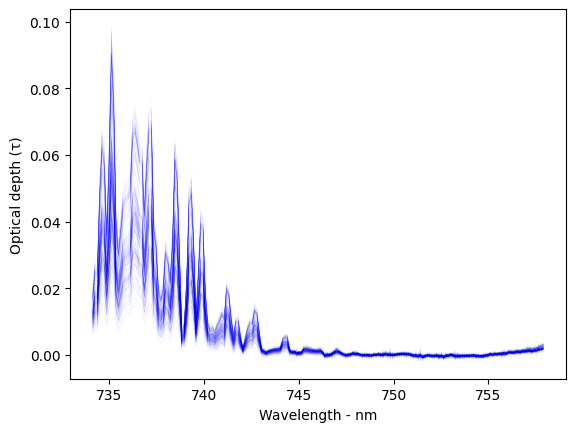

In [27]:
#Computing tau
mu = np.cos(np.radians(africa.variables["VZA"][0,scanline_nocloud,223]))
mu_0 = np.cos(np.radians(africa.variables["SZA"][0,scanline_nocloud,223]))
mu_matrix = np.tile(mu[:, np.newaxis], len(ind))
mu_0_matrix = np.tile(mu_0[:, np.newaxis], len(ind))
reflectance_matrix = africa.variables['Reflectance'][0, scanline_nocloud, 223, ind].data


mu1 = np.cos(np.radians(africa1.variables["VZA"][0,scanline_nocloud1,223]))
mu_01 = np.cos(np.radians(africa1.variables["SZA"][0,scanline_nocloud1,223]))
mu_matrix1 = np.tile(mu1[:, np.newaxis], len(ind))
mu_0_matrix1 = np.tile(mu_01[:, np.newaxis], len(ind))
reflectance_matrix1 = africa1.variables['Reflectance'][0, scanline_nocloud1, 223, ind].data

mu_value =np.concatenate((mu_matrix, mu_matrix1), axis = 0)
mu_0_value = np.concatenate((mu_0_matrix, mu_0_matrix1), axis = 0)
reflectance_value = np.concatenate((reflectance_matrix, reflectance_matrix1), axis = 0)
angle_value = (mu_value + mu_0_value)/mu_value*mu_0_value
tau_value = -np.log(reflectance_value/albedo_value)/angle_value


for idx, i  in enumerate(scanline_nocloud):
    plt.plot(wl[ind], tau_value[idx],color='blue', alpha=0.1, linewidth=0.1)
    plt.xlabel("Wavelength - nm")
    plt.ylabel("Optical depth (τ)")
plt.show()


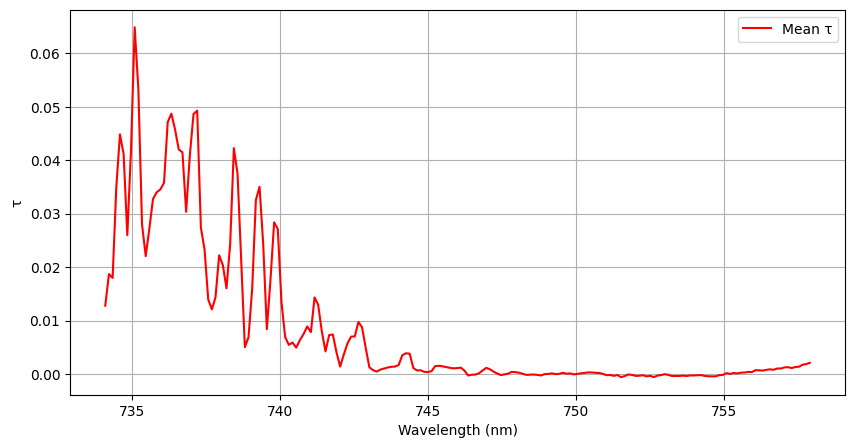

In [28]:
# Plot
tau_mean = tau_value.mean(axis = 0)
plt.figure(figsize=(10, 5))
plt.plot(wl[ind], tau_mean, 'r-', label='Mean τ')
plt.xlabel('Wavelength (nm)')
plt.ylabel('τ')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Compute mode at each wavelength using KDE
mode_spectrum = np.zeros(tau_value.shape[1])  # Shape: (195,)
for i in range(tau_value.shape[1]):
    kde = gaussian_kde(tau_value[:, i])  # KDE for the i-th wavelength
    x = np.linspace(np.min(tau_value[:, i]), np.max(tau_value[:, i]), 100)
    mode_spectrum[i] = x[np.argmax(kde.pdf(x))]  # Mode = peak of KDE

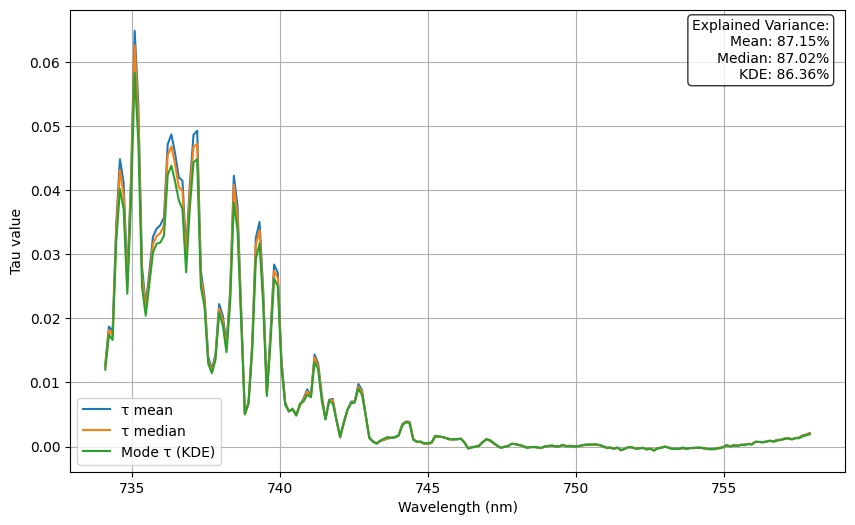

In [ ]:
tau_median = np.median(tau_value, axis=0)
# Compute explained variance for the three methods
explained_variance_mean = 1 - np.var(tau_value - tau_mean, axis=0) / np.var(tau_value, axis=0)
explained_variance_median = 1 - np.var(tau_value - tau_median, axis=0) / np.var(tau_value, axis=0)
explained_variance_KDE = 1 - np.var(tau_value - mode_spectrum, axis=0) / np.var(tau_value, axis=0)

# Take the mean of explained variance across all wavelengths
explained_variance_mean = np.mean(explained_variance_mean)
explained_variance_median = np.mean(explained_variance_median)
explained_variance_KDE = np.mean(explained_variance_KDE)
# Add explained variance information to the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
ax.plot(wl[ind], tau_mean, label="τ mean")
ax.plot(wl[ind], tau_median, label="τ median")
ax.plot(wl[ind], mode_spectrum, label='Mode τ (KDE)')

# Add text box with explained variance information
textstr = '\n'.join((
    f"Explained Variance:",
    f"Mean: {explained_variance_mean:.2%}",
    f"Median: {explained_variance_median:.2%}",
    f"KDE: {explained_variance_KDE:.2%}"))

# Add the text box to the plot
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax.text(0.98, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

# Add labels, legend, and grid
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Tau value")
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

In [13]:
#SOLAR IRRADIANCE -- The same in all areas of the world 
irradiance_vector = africa.variables["irradiance"][223, ind]
#CONVERTING UNITS --- Convert irradiance from mol s⁻¹ m⁻² nm⁻¹ to W m⁻² nm⁻¹
def convert_irradiance(irradiance_mol, wavelength_nm):
    """
    Convert irradiance from mol s⁻¹ m⁻² nm⁻¹ (photon flux) to mW m⁻² nm⁻¹.

    Parameters:
        irradiance_mol (array-like): Irradiance in mol s⁻¹ m⁻² nm⁻¹
        wavelength_nm (array-like): Corresponding wavelengths in nm

    Returns:
        array: Irradiance in mW m⁻² nm⁻¹
    """
    # Constants
    h = 6.62607015e-34  # Planck constant (J·s)
    c = 2.99792458e8    # Speed of light (m/s)
    Na = 6.02214076e23  # Avogadro's number (photons/mol)

    wavelength_m = np.array(wavelength_nm) * 1e-9  # Convert nm to m
    photon_energy = h * c / wavelength_m           # Energy per photon (J)

    irradiance_watts = np.array(irradiance_mol) * Na * photon_energy  # W m⁻² nm⁻¹
    irradiance_mW = irradiance_watts * 1e3  # Convert W to mW

    return irradiance_mW
       
irradiance_value = convert_irradiance(irradiance_vector, wl[ind])

(1, 194)
Fitted parameters:
[-1.88131150e+00  6.14509699e-03 -3.85979016e-06  6.62691514e-01
  3.37609860e-01]


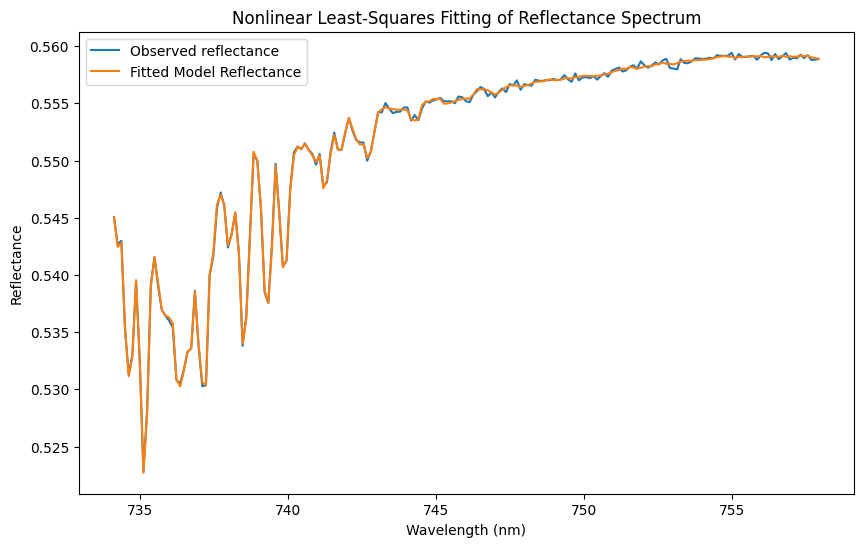

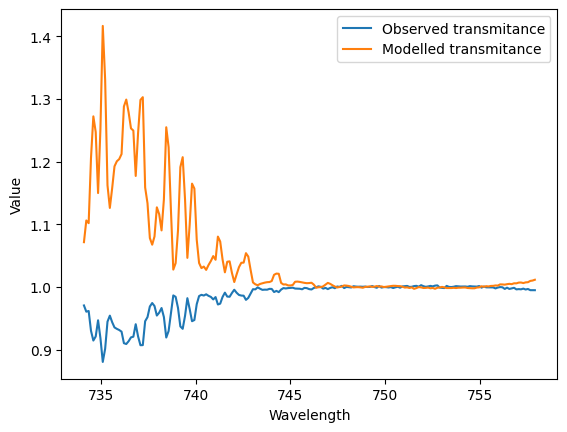

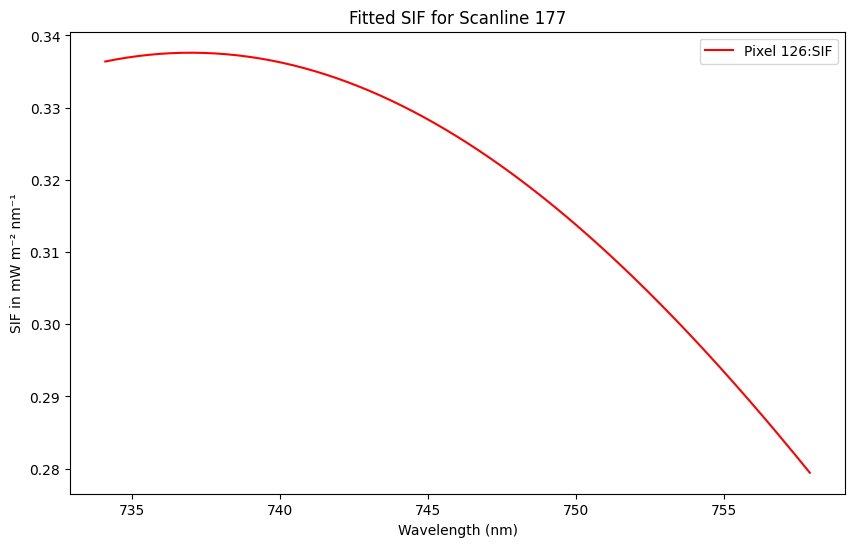

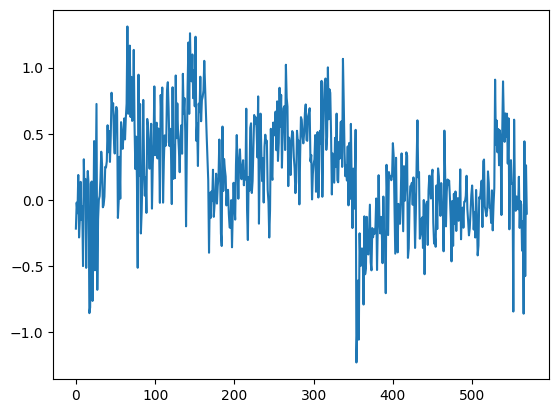

0.20180233272662582


In [10]:
f_matrix = tau_mean.reshape(1, 194)
print(f_matrix.shape)
n = len(f_matrix)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
m = 3
SIF_values_per_scanline = []
for pixel_index, i in enumerate(nocloud_value):
    reflectance_observed = reflectance_value[pixel_index]
    def reflectance_model(lam, *params):

        # Unpack parameters
        a = np.array(params[0:m]) 
        b = np.array(params[m:n+m])
        c = params[n+m]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        poly_term = sum(a[j] * lam**j for j in range(m))
        baseline = poly_term * np.exp(-attenuation)
    
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_value[pixel_index]) / ((1 / mu_value[pixel_index]) + (1 / mu_0_value[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_value[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence
    
    # Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0.5]*m + [0.5] * n + [0.5]

    # lower_bounds = [-np.inf] * n + [0]  # Allow b parameters to be anything, but c must be ≥ 0
    # upper_bounds = [np.inf] * n + [np.inf]  # No upper bound on any parameter
    
    # Fit the model to the observed reflectance
    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0) #, bounds=(lower_bounds, upper_bounds),maxfev=10000)

    SIF_values_per_scanline.append(popt[-1])

    if pixel_index == 100:
        print("Fitted parameters:")
        print(popt)
        
        # ---- Plot the results ----
        
        R_fit = reflectance_model(wl[ind], *popt)
        
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
        plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Reflectance")
        plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
        plt.savefig("LM-fitting_mean")
        plt.legend()
        plt.show()
        
        #Plot transmittance observed and modelled
        transmitance_tropomi = np.exp(-(np.reciprocal(mu_value) + np.reciprocal(mu_0_value))*tau_value)[100]
        # Extract the fitted PCA coefficients (b0 to b9)
        b_fit = np.array(popt[0:n])
        # Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
        attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)
        
        transmitance_modelled = np.exp(-(np.reciprocal(mu_value[100]) + np.reciprocal(mu_0_value[100]))*attenuation_fit)
        plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
        plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
        plt.xlabel('Wavelength')
        plt.ylabel('Value')
        plt.legend(loc="best")
        plt.savefig("ML_fit_mean_tropomi")
        plt.show()
        # Pre-compute the Gaussian (same for every pixel if center and width are fixed)
        gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
        
        # For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud[100]}:SIF", color='red')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("SIF in mW m⁻² nm⁻¹")
        plt.title("Fitted SIF for Scanline 177")
        plt.legend()
        plt.savefig("ML_fit_mean_SIF")
        plt.show()
plt.plot(SIF_values_per_scanline)
plt.show() 
print(np.mean(SIF_values_per_scanline))

(1, 194)
Fitted parameters:
[ 0.70071245 -0.04521723]


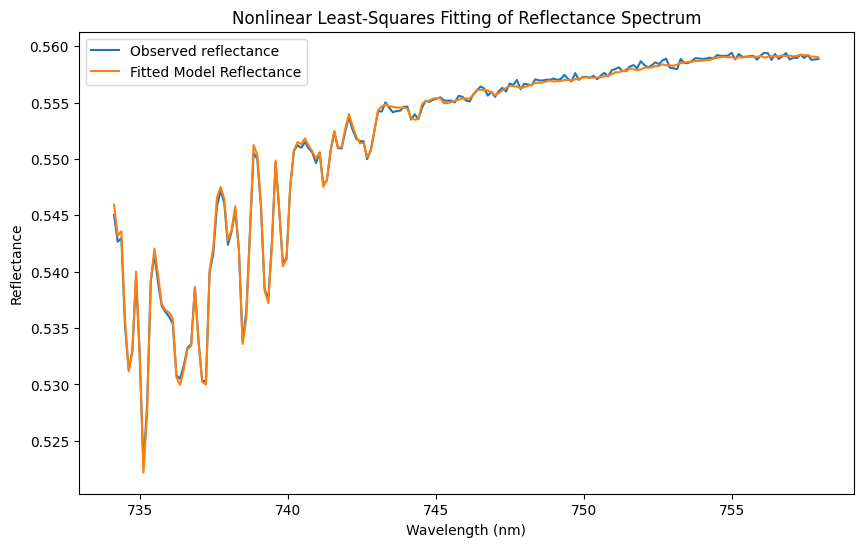

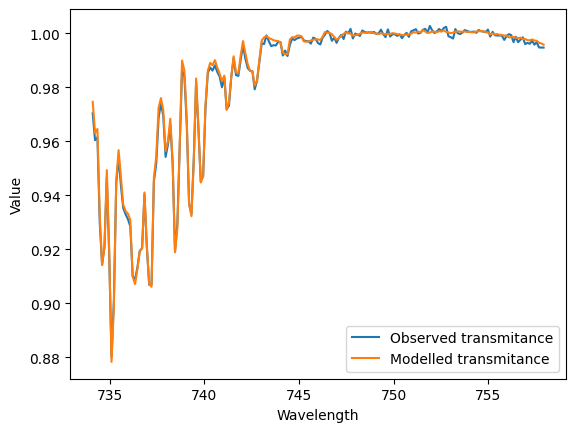

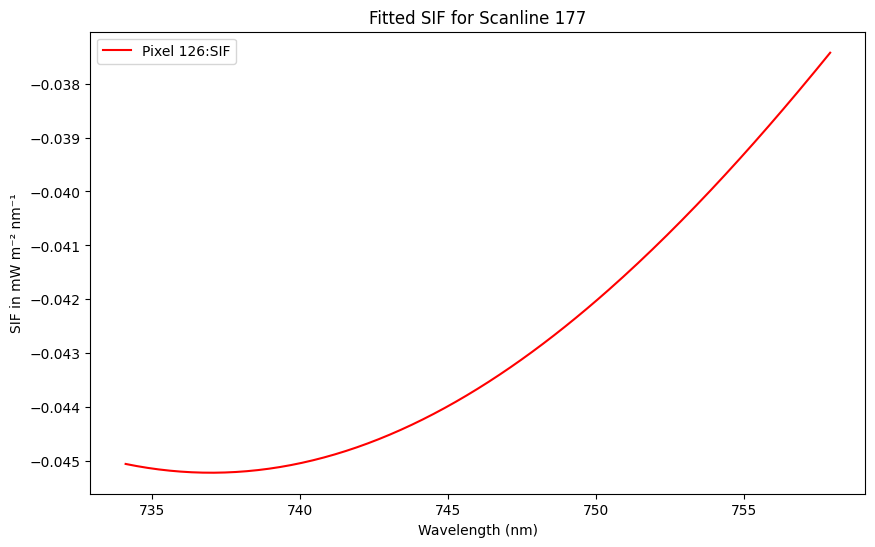

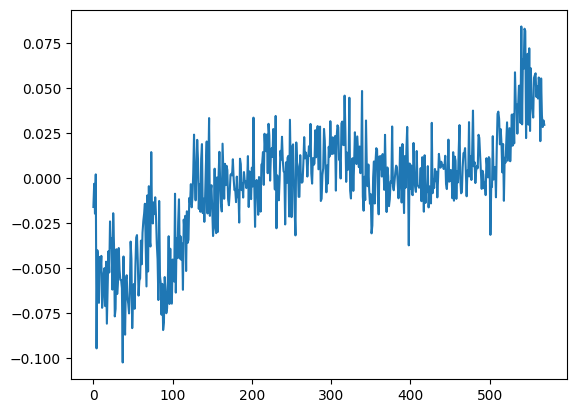

In [11]:
f_matrix = tau_mean.reshape(1, 194)
print(f_matrix.shape)
n = len(f_matrix)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
SIF_values_per_scanline = []
for pixel_index, i in enumerate(nocloud_value):
    reflectance_observed = reflectance_value[pixel_index]
    def reflectance_model(lam, *params):
    
        # Unpack parameters
        b = np.array(params[0:n])
        c = params[n]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        # Baseline reflectance term:
        baseline = albedo_value[pixel_index] * np.exp(-attenuation)
        
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_value[pixel_index]) / ((1 / mu_value[pixel_index]) + (1 / mu_0_value[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_value[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence
    
    # Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0.5] * n + [0.5]
    # lower_bounds = [-np.inf] * n + [0]  # Allow b parameters to be anything, but c must be ≥ 0
    # upper_bounds = [np.inf] * n + [np.inf]  # No upper bound on any parameter
    
    # Fit the model to the observed reflectance
    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0) #, bounds=(lower_bounds, upper_bounds),maxfev=10000)

    SIF_values_per_scanline.append(popt[-1])
    if pixel_index == 100:
        print("Fitted parameters:")
        print(popt)
        
        # ---- Plot the results ----
        
        R_fit = reflectance_model(wl[ind], *popt)
        
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
        plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Reflectance")
        plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
        plt.savefig("LM-fitting_mean")
        plt.legend()
        plt.show()
        
        #Plot transmittance observed and modelled
        transmitance_tropomi = np.exp(-(np.reciprocal(mu_value) + np.reciprocal(mu_0_value))*tau_value)[100]
        # Extract the fitted PCA coefficients (b0 to b9)
        b_fit = np.array(popt[0:n])
        # Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
        attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)
        
        transmitance_modelled = np.exp(-(np.reciprocal(mu_value[100]) + np.reciprocal(mu_0_value[100]))*attenuation_fit)
        plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
        plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
        plt.xlabel('Wavelength')
        plt.ylabel('Value')
        plt.legend(loc="best")
        plt.savefig("ML_fit_mean_tropomi")
        plt.show()
        # Pre-compute the Gaussian (same for every pixel if center and width are fixed)
        gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
        
        # For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud[100]}:SIF", color='red')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("SIF in mW m⁻² nm⁻¹")
        plt.title("Fitted SIF for Scanline 177")
        plt.legend()
        plt.savefig("ML_fit_mean_SIF")
        plt.show()

plt.plot(SIF_values_per_scanline)
plt.show()  

In [12]:
###SIF retrieaval 

In [30]:
h2 = nc.Dataset('Data/S5P_OFFL_L1C_SIFTRS_20240206T172817_20240206T173755_32735_93_010100_20250228T104827_irr.nc')
amazon = h2.groups['amazon']

In [31]:
#Remove clouds
scanline_nocloud2 = []
for n in range(406):
    if (amazon.variables['CloudFraction'][0,n,223]<0.4).all():
            if (amazon.variables["Reflectance_err"][0,n,223]<80).all():
                if (amazon.variables["SZA"][0,n,223]<75).all():
                    scanline_nocloud2.append(n)
sc_nc2 = len(scanline_nocloud2)
#Fixing albedo 

ref_na2 = amazon.variables["Reflectance"][0, scanline_nocloud2, 223, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_alb2 = np.zeros((sc_nc2, 194))
for i in range(sc_nc2):
    poly_sa = po.polyfit (wl[ind_na], ref_na2[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa) 
    surf_alb2[i, :] = surf_alb

#Computing tau
mu2 = np.cos(np.radians(amazon.variables["VZA"][0,scanline_nocloud2,223]))
mu_02 = np.cos(np.radians(amazon.variables["SZA"][0,scanline_nocloud2,223]))
mu_matrix2 = np.tile(mu2[:, np.newaxis], (1,194))
mu_0_matrix2 = np.tile(mu_02[:, np.newaxis],(1, 194))
reflectance_matrix2 = amazon.variables['Reflectance'][0, scanline_nocloud2, 223, ind]


tau2 = -np.log(reflectance_matrix2/surf_alb2)/ (np.reciprocal(mu_matrix2)+ np.reciprocal(mu_0_matrix2))

tau_mean2 = tau2.mean(axis = 0)

(1, 194)
Fitted parameters:
[-8.36651801e+00  2.24239251e-02 -1.45190373e-05  3.92475254e+00
 -1.93150463e+03]


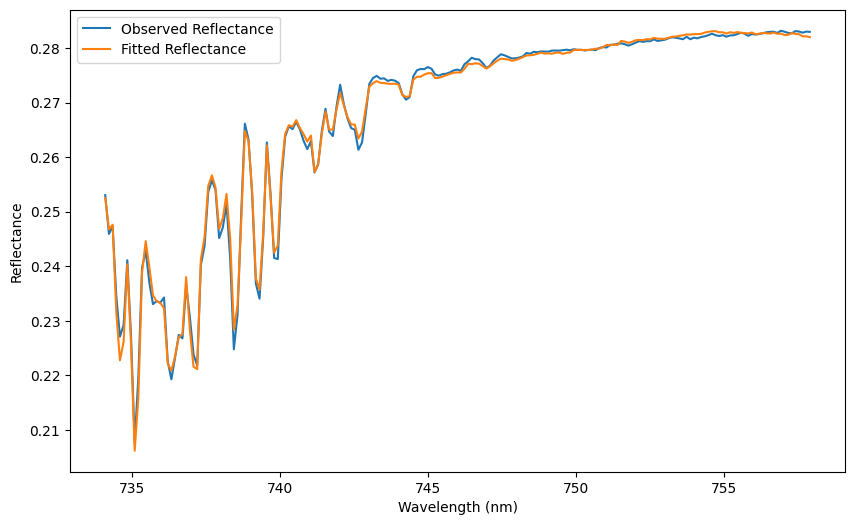

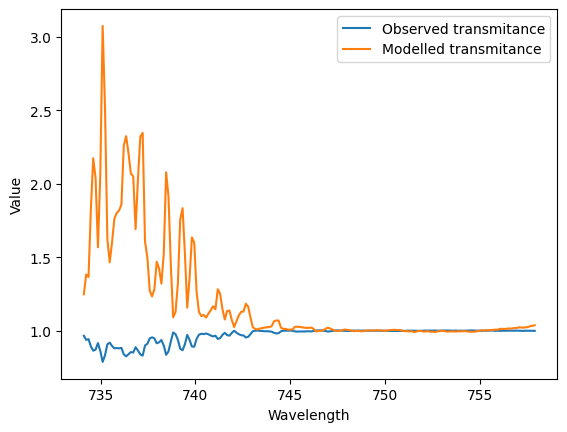

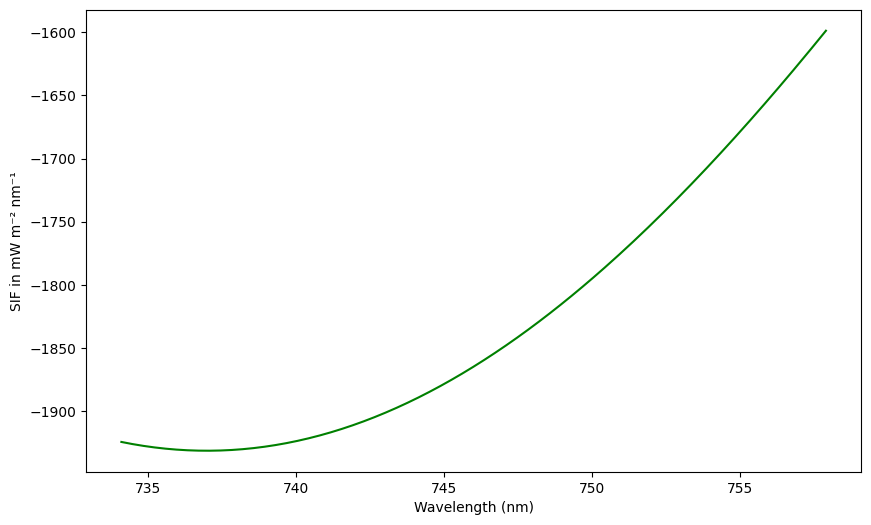

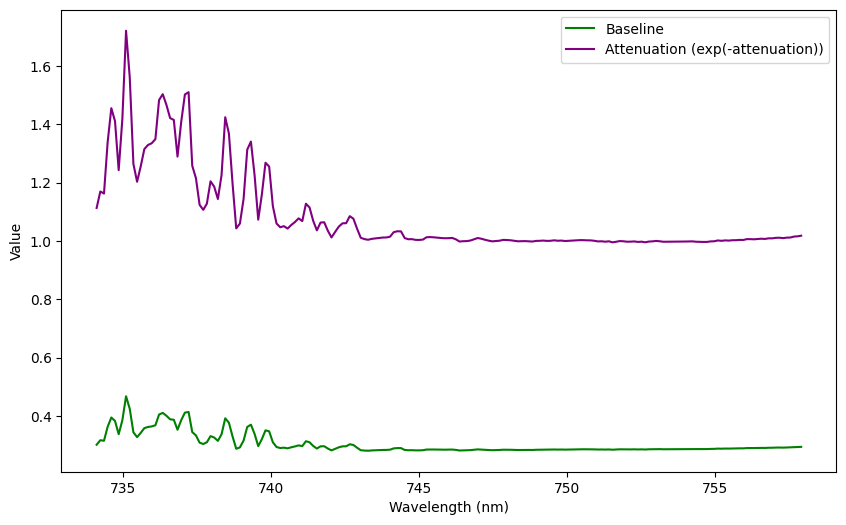

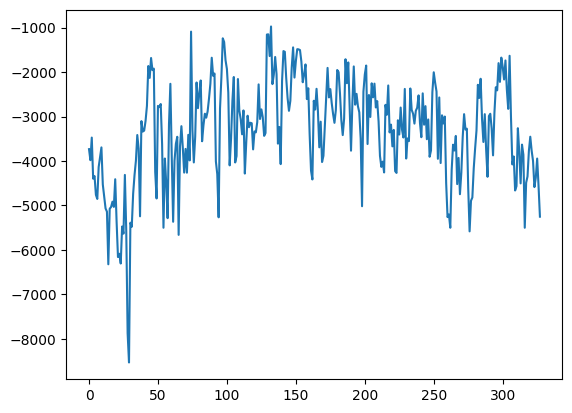

-3331.0094616496494


In [39]:
f_matrix = tau_mean.reshape(1, 194)
print(f_matrix.shape)
n = len(f_matrix)
SIF_values_per_scanline_m_A = []
for pixel_index, i in enumerate(scanline_nocloud2):
    reflectance_observed = amazon.variables['Reflectance'][0, i, 223,ind].data
    m = 3
    def reflectance_model(lam, *params):

        # Unpack parameters
        a = np.array(params[0:m]) 
        b = np.array(params[m:n+m])
        c = params[n+m]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        poly_term = sum(a[j] * lam**j for j in range(m))
        baseline = poly_term * np.exp(-attenuation)
    
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_matrix2[pixel_index]) / ((1 / mu_matrix2[pixel_index]) + (1 / mu_0_matrix2[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_matrix2[pixel_index] * irradiance_value*1000)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence

# Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0.5]*m + [0.5] * n + [0.01]
    # lower_bounds = [-np.inf] * (m + n) + [-1]  # c >= -2
    # upper_bounds = [np.inf] * (m + n) + [2]    # c <= 2

    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0) #, bounds=(lower_bounds, upper_bounds))

    SIF_values_per_scanline_m_A.append(popt[-1])
    if pixel_index == 100:
        popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0)
        
        print("Fitted parameters:")
        print(popt)
        
        # ---- Plot the results ----
        
        R_fit = reflectance_model(wl[ind], *popt)
        
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], reflectance_observed, label="Observed Reflectance")
        plt.plot(wl[ind], R_fit, label="Fitted Reflectance")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Reflectance")
        #plt.savefig("LM-fitting_mean_A")
        plt.legend()
        plt.show()
        
        #Plot transmittance observed and modelled
        transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix2) + np.reciprocal(mu_0_matrix2))*tau2)[100]
        # Extract the fitted PCA coefficients (b0 to b9)
        b_fit = np.array(popt[0:n])
        # Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
        attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)
        
        transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*attenuation_fit)
        plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
        plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
        plt.xlabel('Wavelength')
        plt.ylabel('Value')
        plt.legend(loc="best")
        #plt.savefig("LM_fit_mean_A")
        plt.show()
        # Pre-compute the Gaussian (same for every pixel if center and width are fixed)
        gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
        
        # For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], popt[-1]*gaussian_full,  color='green')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("SIF in mW m⁻² nm⁻¹")
        #plt.savefig("LM_fit_SIF_mean_A")
        plt.show()

        # Compute the baseline and attenuation for plotting
        baseline_fit = sum(popt[j] * wl[ind]**j for j in range(m)) * np.exp(-attenuation_fit)
        attenuation_fit_exp = np.exp(-attenuation_fit)

        # Plot the baseline
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], baseline_fit, label="Baseline", color='green')
        plt.plot(wl[ind], attenuation_fit_exp, label="Attenuation (exp(-attenuation))", color='purple')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Value")
        plt.legend()
        plt.show()


sif_array = np.array(SIF_values_per_scanline_m_A)

# Plot the filtered values
plt.plot(SIF_values_per_scanline_m_A)
plt.show()
print(np.mean(SIF_values_per_scanline_m_A))

(1, 194)
Fitted parameters:
[3.75430328e+00 2.03669145e-03]


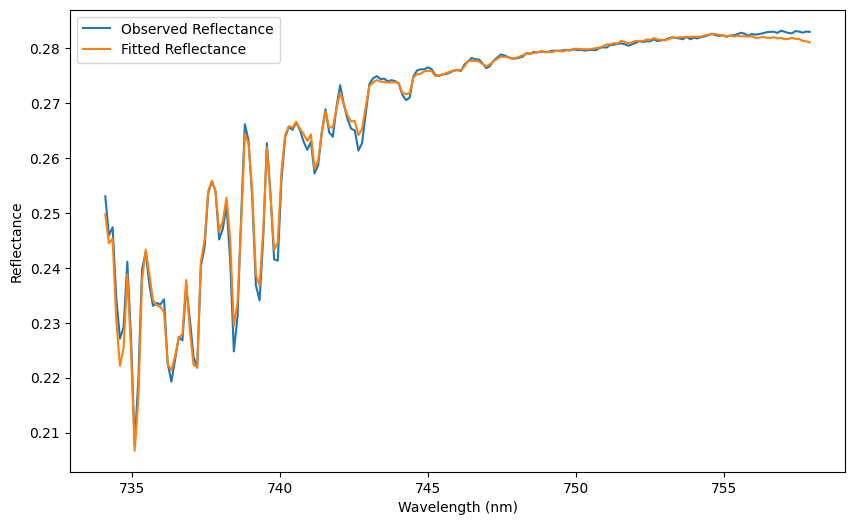

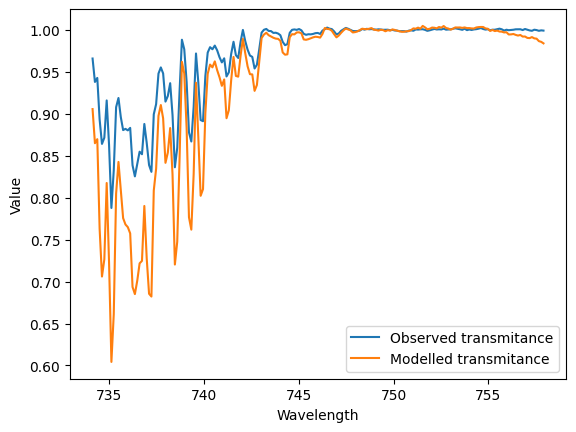

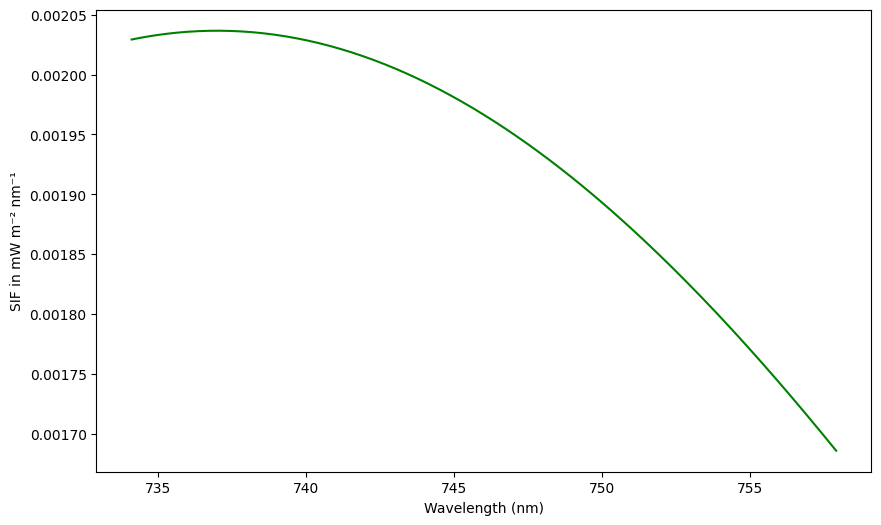

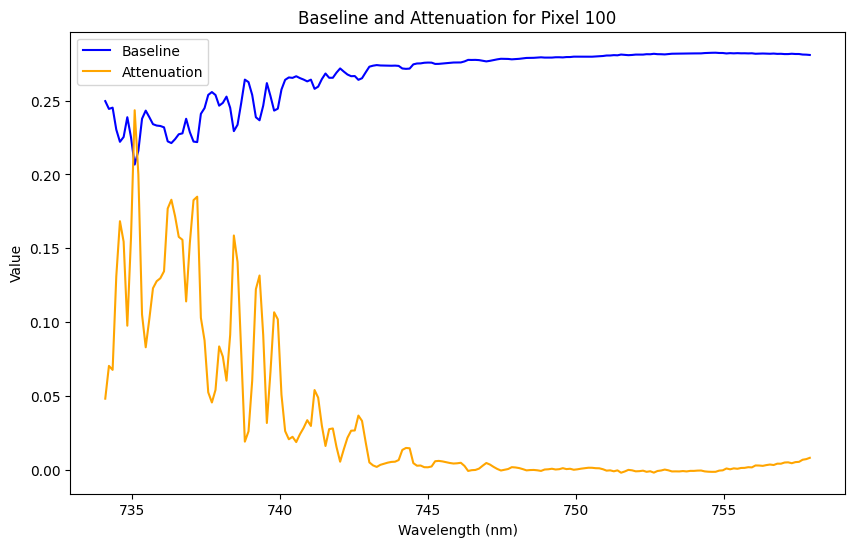

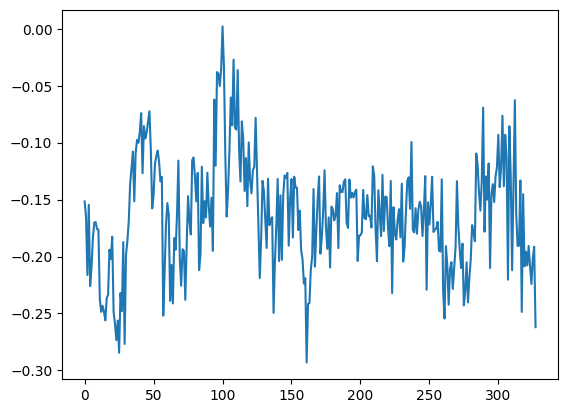

-0.1628339053520483


In [ ]:
f_matrix = tau_mean.reshape(1, 194)
print(f_matrix.shape)
n = len(f_matrix)
pixel_index = 100
SIF_values_per_scanline_A = []
for pixel_index, i in enumerate(scanline_nocloud2):
    reflectance_observed = amazon.variables['Reflectance'][0, i, 223,ind].data
    def reflectance_model(lam, *params):
    
        # Unpack parameters
        
        b = np.array(params[0:n])
        c = params[n]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        # Baseline reflectance term:
        baseline = surf_alb2[pixel_index] * np.exp(-attenuation)
        
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_matrix2[pixel_index]) / ((1 / mu_matrix2[pixel_index]) + (1 / mu_0_matrix2[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_matrix2[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence
    
    # Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0] * n + [0]
    
    # Fit the model to the observed reflectance
    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0)
    SIF_values_per_scanline_A.append(popt[-1])
    
    if pixel_index == 100:
        print("Fitted parameters:")
        print(popt)
        
        # ---- Plot the results ----
        
        R_fit = reflectance_model(wl[ind], *popt)
        
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], reflectance_observed, label="Observed Reflectance")
        plt.plot(wl[ind], R_fit, label="Fitted Reflectance")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Reflectance")
        #plt.savefig("LM-fitting_AE_A")
        plt.legend()
        plt.show()
        
        #Plot transmittance observed and modelled
        transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix2) + np.reciprocal(mu_0_matrix2))*tau2)[100]
        # Extract the fitted PCA coefficients (b0 to b9)
        b_fit = np.array(popt[0:n])
        # Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
        attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)
        
        transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*attenuation_fit)
        plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
        plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
        plt.xlabel('Wavelength')
        plt.ylabel('Value')
        plt.legend(loc="best")
        #plt.savefig("LM_fit_AE_transmitance_A")
        plt.show()
        # Pre-compute the Gaussian (same for every pixel if center and width are fixed)
        gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
        
        # For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], popt[-1]*gaussian_full, color='green')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("SIF in mW m⁻² nm⁻¹")
        plt.show()

        # Compute baseline and attenuation for the pixel at index 100
        b_fit = np.array(popt[0:n])
        attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)

        baseline_fit = surf_alb2[100] * np.exp(-attenuation_fit)

        # Plot baseline and attenuation
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], baseline_fit, label="Baseline", color='blue')
        plt.plot(wl[ind], attenuation_fit, label="Attenuation", color='orange')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Value")
        plt.legend()
        plt.show()
plt.plot(SIF_values_per_scanline_A)
plt.show()
print(np.mean(SIF_values_per_scanline_A))        


In [ ]:
#np.savez("sif_values_mean.npz", m_alb=SIF_values_per_scanline_m_A, alb = SIF_values_per_scanline_A)